# Badanie zależności między zdrową dietą mieszkańców, a śmiertelnością na COVID-19 w danym państwie

Celem poniższej pracy jest przeprowadzenie analizy eksploracyjnej a nastepnie analizy regresji dla danych dotyczących rocznego spożycia poszczególnych składników odżywczych przez populację z podziałem na kraje świata, poprzez które chcemy odpowiedzieć na pytanie czy zwyczaje żywieniowe danego kraju mają wpływ na większą śmiertelność na COVID-19 jego obywateli. Wykorzystane dane pochodzą z serwisu kaggle (https://www.kaggle.com/mariaren/covid19-healthy-diet-dataset) i zostały zebrane przez prywatną osobę na podsatwie:
* danych dotyczących różnych ilości dostarczanych grup żywności, wartości odżywczych, otyłości i wartości procentowych niedożywienia ze strony Organizacji Narodów Zjednoczonych ds. Wyżywienia i Rolnictwa (http://www.fao.org/faostat/en/#home)
* danych dotyczących COVID-19  - potwierdzonych zachorowań, zgonów, wyzdrowień i aktywnych przypadków uzyskanych z Johns Hopkins Center for Systems Science and Engineering (https://coronavirus.jhu.edu/map.html) [stan na 02/06/21]
* danych dotyczących populacji ze strony Biura Referencyjnego ds. Ludności (https://www.prb.org/)

Zdecydowaliśmy się na wybór danych pochodzących z pliku "Food_supply_kcal_Data.csv", ponieważ zbiór ten przedstwia procentowy udział produtków w podaży energii obywateli poszczególnych państw, co według nas najlepiej odzwierciedla spożycie poszczególnych produktów, składników odżywczych przez obywateli danego państwa.




In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
import statistics

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn import linear_model

from sklearn.model_selection import train_test_split

In [ ]:
food_supply = pd.read_csv("Food_Supply_kcal_Data.csv")

In [ ]:
food_supply.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Milk - Excluding Butter,Miscellaneous,Offals,Oilcrops,Pulses,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,2.4512,0.0250,0.1251,0.1751,0.5003,0.1001,0.3252,0.0750,0.0,2.2261,0.1251,45.2476,2.3012,0.7504,4.5,29.8,0.142134,0.006186,0.123374,0.012574,38928000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,9.9441,0.0588,0.2648,1.0886,0.8091,0.0000,1.2651,0.2501,0.0,3.4422,0.3972,33.9070,2.8244,2.7508,22.3,6.2,2.967301,0.050951,1.792636,1.123714,2838000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,3.9869,0.1045,0.0597,0.2688,1.0900,0.1195,1.9262,0.1493,0.0,3.9869,0.2240,43.9749,5.7638,2.0457,26.6,3.9,0.244897,0.006558,0.167572,0.070767,44357000.0,%
3,Angola,1.9388,4.6927,0.2644,0.0,18.3521,0.0441,0.8372,2.3133,2.9302,0.5067,0.0661,0.1102,1.0795,1.4981,0.0000,12.6239,0.0441,0.0,2.7539,0.0000,45.3184,4.2741,0.3525,6.8,25,0.061687,0.001461,0.056808,0.003419,32522000.0,%
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0,13.7215,0.2057,1.7280,3.6824,7.0356,4.6904,0.3086,0.1646,0.5966,0.4526,0.3497,0.8434,0.4937,0.0,5.8218,0.0823,34.6225,4.6904,1.2960,19.1,NaN,0.293878,0.007143,0.190816,0.095918,98000.0,%


# Braki danych


Zbiór przedstawia dane dla 170 krajów, jednak tylko dla 164 spośród tych krajów znana jest śmiertelność na covid czyli zmienna przez nas objaśniana. Zastosowanie metod imputacji danych przy tak małej ogólnej liczbie obserwacji znacznie wpłynie na jakość wyników, dlatego zbiór zostanie skrócony do tych krajów dla których śmiertelność na COVID-19 jest znana.

In [ ]:
dataset = food_supply
dataset = dataset.drop(['Confirmed', 'Recovered',
       'Active', 'Population', 'Unit (all except Population)'], axis=1)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   170 non-null    object 
 1   Alcoholic Beverages       170 non-null    float64
 2   Animal Products           170 non-null    float64
 3   Animal fats               170 non-null    float64
 4   Aquatic Products, Other   170 non-null    float64
 5   Cereals - Excluding Beer  170 non-null    float64
 6   Eggs                      170 non-null    float64
 7   Fish, Seafood             170 non-null    float64
 8   Fruits - Excluding Wine   170 non-null    float64
 9   Meat                      170 non-null    float64
 10  Milk - Excluding Butter   170 non-null    float64
 11  Miscellaneous             170 non-null    float64
 12  Offals                    170 non-null    float64
 13  Oilcrops                  170 non-null    float64
 14  Pulses    

In [ ]:
dataset = dataset.dropna(subset=['Deaths'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 0 to 169
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   164 non-null    object 
 1   Alcoholic Beverages       164 non-null    float64
 2   Animal Products           164 non-null    float64
 3   Animal fats               164 non-null    float64
 4   Aquatic Products, Other   164 non-null    float64
 5   Cereals - Excluding Beer  164 non-null    float64
 6   Eggs                      164 non-null    float64
 7   Fish, Seafood             164 non-null    float64
 8   Fruits - Excluding Wine   164 non-null    float64
 9   Meat                      164 non-null    float64
 10  Milk - Excluding Butter   164 non-null    float64
 11  Miscellaneous             164 non-null    float64
 12  Offals                    164 non-null    float64
 13  Oilcrops                  164 non-null    float64
 14  Pulses    

Po usunięciu braków dla śmiertelności COVID-19 wciąż zostają jednak puste wartości dla Obesity oraz Undernourished. Ponieważ są to już zmienne objaśniające więc ich poprawność nie jest aż tak istotna, a ilość braków jest niewielka, zastosujemy imputację danych metodą najbliższego sąsiada. W ten sposób obserwacje dostają takie wartości brakującej zmiennej jak średnia dwóch najbardziej podobnych obserwacji pod względem nie brakujących zmiennych.

In [ ]:
dataset['Undernourished'] = dataset['Undernourished'].replace('<2.5', 2.5).astype('float64')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 0 to 169
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   164 non-null    object 
 1   Alcoholic Beverages       164 non-null    float64
 2   Animal Products           164 non-null    float64
 3   Animal fats               164 non-null    float64
 4   Aquatic Products, Other   164 non-null    float64
 5   Cereals - Excluding Beer  164 non-null    float64
 6   Eggs                      164 non-null    float64
 7   Fish, Seafood             164 non-null    float64
 8   Fruits - Excluding Wine   164 non-null    float64
 9   Meat                      164 non-null    float64
 10  Milk - Excluding Butter   164 non-null    float64
 11  Miscellaneous             164 non-null    float64
 12  Offals                    164 non-null    float64
 13  Oilcrops                  164 non-null    float64
 14  Pulses    

In [ ]:
from sklearn.impute import KNNImputer

# Syntax of the reset_index() function in pandas
dataset.reset_index(inplace=True, drop=True)
X = dataset.drop(['Country'], axis=1).values
imputer = KNNImputer(n_neighbors=2, weights="uniform")

df = pd.DataFrame(imputer.fit_transform(X),columns = dataset.columns[1:27])
dataset = pd.concat([dataset['Country'], df], axis=1)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   164 non-null    object 
 1   Alcoholic Beverages       164 non-null    float64
 2   Animal Products           164 non-null    float64
 3   Animal fats               164 non-null    float64
 4   Aquatic Products, Other   164 non-null    float64
 5   Cereals - Excluding Beer  164 non-null    float64
 6   Eggs                      164 non-null    float64
 7   Fish, Seafood             164 non-null    float64
 8   Fruits - Excluding Wine   164 non-null    float64
 9   Meat                      164 non-null    float64
 10  Milk - Excluding Butter   164 non-null    float64
 11  Miscellaneous             164 non-null    float64
 12  Offals                    164 non-null    float64
 13  Oilcrops                  164 non-null    float64
 14  Pulses    

# Analiza eksploracyjna


## Macierz korelacji##

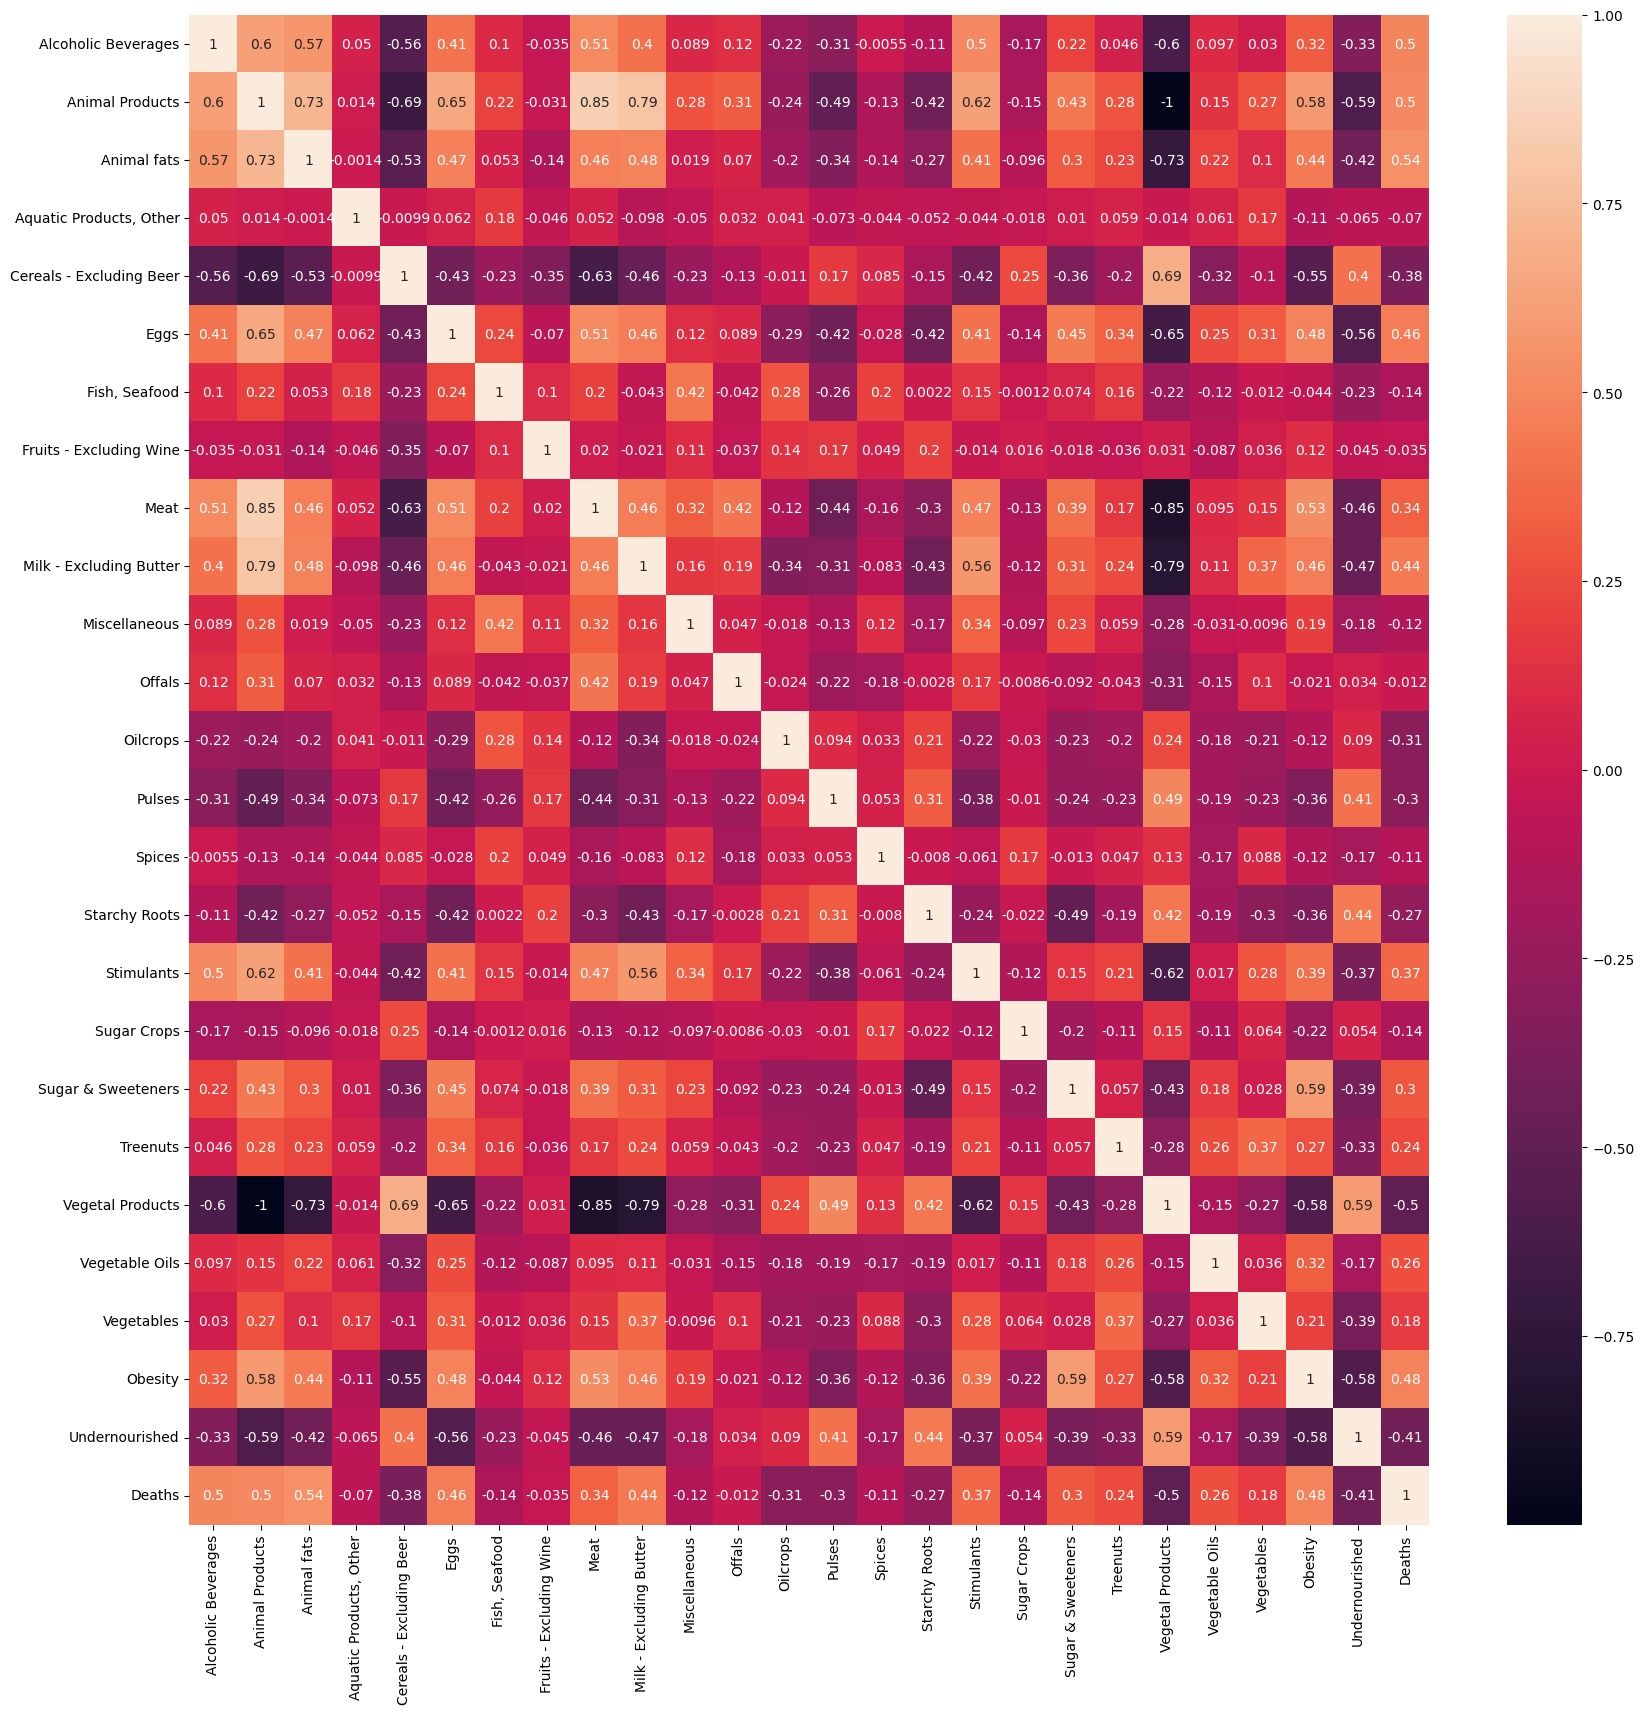

In [ ]:
corr_heatmap = dataset.corr()
plt.figure(figsize=(20, 20), dpi=100)
sns.heatmap(corr_heatmap, annot=corr_heatmap)

Na podstawie macierzy korelacji możemy stwierdzić że największa zależność liniowa pomiędzy poniższymi zmiennymi, a zmienną objaśnianą istnieje dla:

* Alkoholic Beverages (0.5)
* Animal Products (0.5)
* Animal fats (0.54)
* Eggs (0.46)
* Vegetal Products (0.5)
* Obesity(0.48)

Jednocześnie istnieje idealna odwrotna liniowa zależnść (korelacja równa -1.0) dla zmiennych Animal Products i Vegetables Products. Jedna z tych zmiennych musi zostać koniecznie usunięta.

Jednocześnie wysokie korelacje istnieją dla :
* Milk oraz Animal Products (0.79)
* Meat oraz Animal Products (0.85)

Oraz tych zmiennych z Vegetables Products.

Jednocześnie bardzo małe zależności liniowe (korelacja bliska 0) występują dla zmiennej objaśnianej a Fruits oraz Offals. Zmienne te zostaną usunięte. Usunięta zostanie również zmienna Miscellaneous ponieważ, oznacza ona produkty mieszane, czyli niejako nie mówi nam nic o faktycznych wartościach odżywczych które są spożywane.

Zostanie również usunięta jedna z kategorii oznaczających ryby i owoce morza oraz produkty morskie, ponieważ produkty morskie zawierają ryby i owoce morza.


*Aquatic products means any food or fiber products obtained through the practice of aquaculture, including mariculture; or by harvest from the sea when such products are cultured or landed in this state. Such products include but are not limited to fish, shellfish, seaweed or other water based plant life.*

*Miscellaneous - composed of or containing a variety of things; mixed; varied.*

In [ ]:
dataset = dataset.drop(['Vegetal Products','Offals','Fruits - Excluding Wine', 'Miscellaneous', 'Aquatic Products, Other'], axis=1)

## Statystyki opisowe ##


Już po obejrzeniu statystyk opisowych można dojść do wniosku że duzo zmiennych jest narażone na duże odstępstwa od rozkładu normalnego tzn. ich średnie są dużo większe niż mediany, między innymi:


* Animal fats
* Oilcrops 	
* Pulses
* Starchy Roots
* Undernourished

Niepokojący rozkład ma również Sugar Crops, ponieważ wszystkie 3 kwantyle (25%, 50%, 75%) wynoszą dla tej zmiennej 0.

In [ ]:
dataset.describe()

,Alcoholic Beverages,Animal Products,Animal fats,Cereals - Excluding Beer,Eggs,"Fish, Seafood",Meat,Milk - Excluding Butter,Oilcrops,Pulses,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetable Oils,Vegetables,Obesity,Undernourished,Deaths
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,1.341392,9.259680,1.276999,20.319704,0.428540,0.607802,3.842554,2.956138,1.040646,1.113349,0.186888,3.124957,0.304726,0.017697,4.866630,0.264360,4.898168,1.082252,18.738415,11.034146,0.039370
std,1.068834,4.766646,1.299003,6.490782,0.308497,0.549763,2.198052,2.024847,1.441129,1.207545,0.239864,3.952105,0.312174,0.072080,2.120514,0.289350,2.182019,0.653259,9.403715,11.706171,0.048718
min,0.000000,1.623700,0.000000,8.956500,0.018800,0.000000,0.298000,0.116900,0.017900,0.000000,0.000000,0.293800,0.000000,0.000000,0.678600,0.000000,0.932500,0.095700,2.100000,2.500000,0.000000
25%,0.388900,5.031950,0.349750,14.734600,0.139350,0.237500,2.064850,1.112050,0.298625,0.297875,0.037625,1.112375,0.078775,0.000000,3.435525,0.044125,3.107900,0.602000,8.675000,2.500000,0.002013
50%,1.244600,8.933250,0.877500,19.619950,0.399150,0.466750,3.668800,2.766450,0.623850,0.720500,0.087350,1.544850,0.206750,0.000000,4.793350,0.176050,4.682800,1.001300,21.300000,6.400000,0.011998
75%,2.042250,13.160125,1.776900,24.828550,0.634925,0.861950,5.161625,4.358275,1.159675,1.544250,0.233800,2.859750,0.417750,0.000000,6.383900,0.394200,6.538000,1.349850,25.700000,14.550000,0.069503
max,5.157400,22.291100,7.800700,37.526500,1.446100,4.418300,10.567400,9.944100,10.482200,7.563800,1.220200,19.675900,2.009000,0.593000,9.549200,1.421000,10.383900,3.352400,45.500000,59.600000,0.185428


Również wykresy pudełkowe (boxploty) pokazują problemy z rozkładami wartości dla wielu zmiennych. Dla prawie wszystkich zmiennych odległości między 3 kwartylem, a wartością maksymalną jest znacznie większa niż wartością minimalną a 1 kwartylem. Wyjątkiem jest zmienna Sugar & Sweeteners. Dla której rozkład jest dość równomiernie rozłożony między kwartylami. Jak już zauważono wcześniej problematyczną zmienną jest na pewno - Sugar crops. Wszystkie 3 kwartyle na wykresie boxplot znajdują się w zerze.

Dzięki wykresom skrzypcowym (violinplot) możemy zobaczyć rozkład poszczególnych zmiennych. Widzimy, że w różnych krajach spożywane są bardzo różne produkty. Dla przykładu Animal Products odpowiadają w niektórych krajach tylko za kilka % dostarczanej energi, a w niektórych ponad 15%. Również spożycie innych produktów takich jak np Alcoholic Beverages czy Meat jest bardzo zróżnicowane. Niektóre produkty natomiast są spożywane w większości krajów w podobnych ilościach, są to np. Starchy Roots.

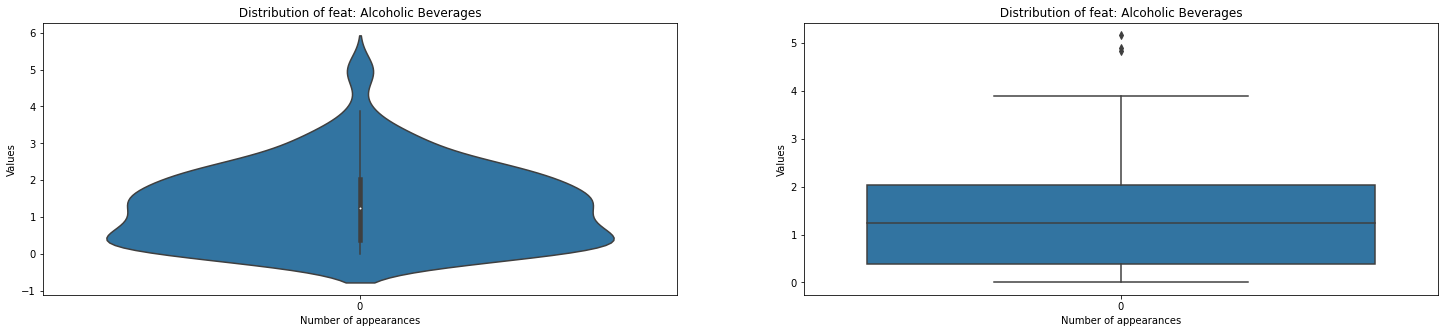

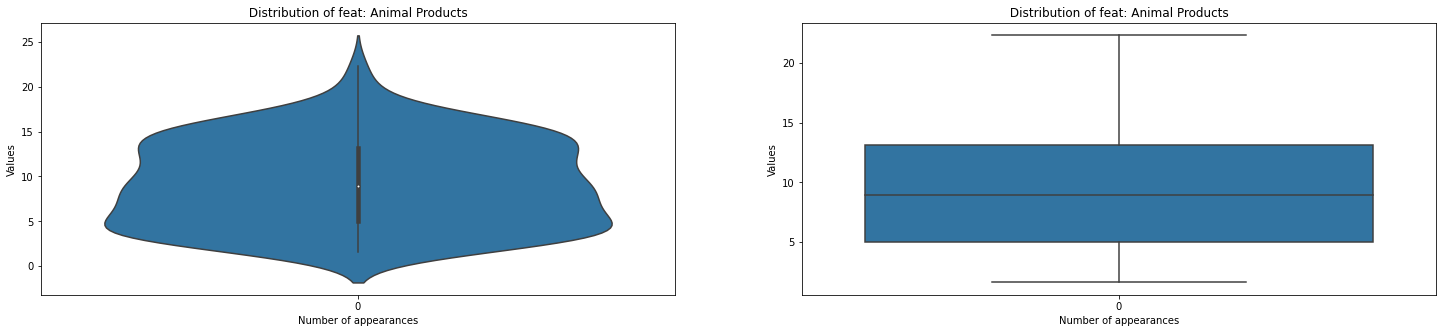

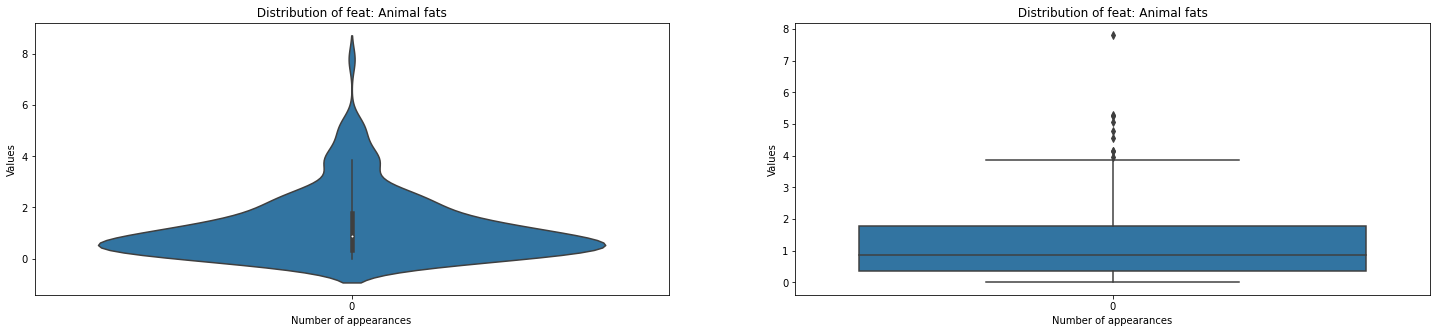

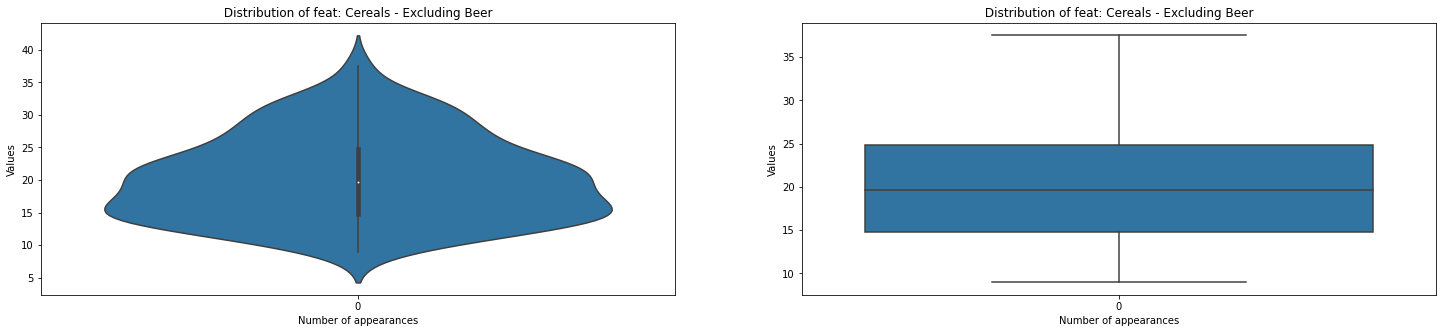

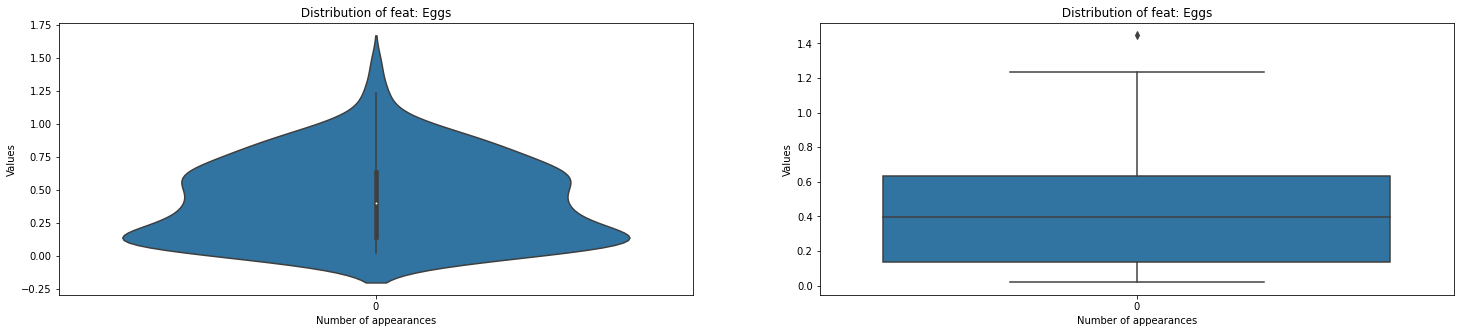

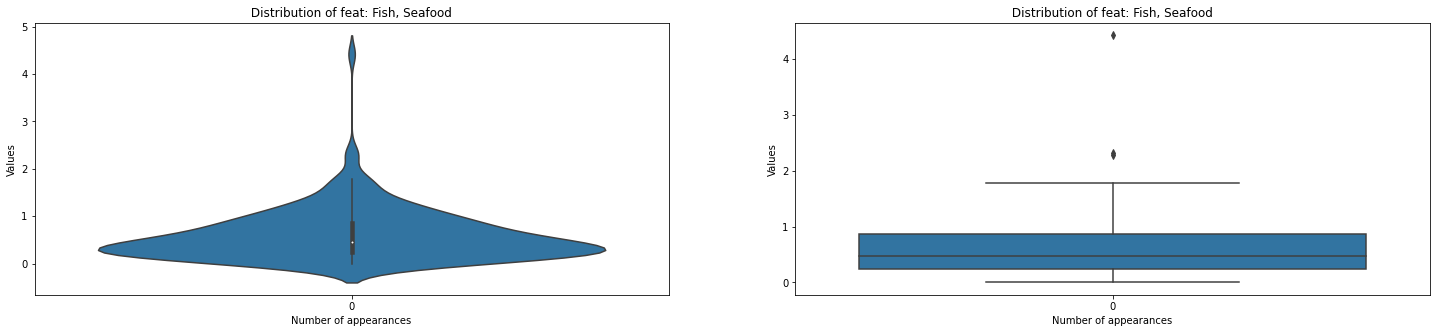

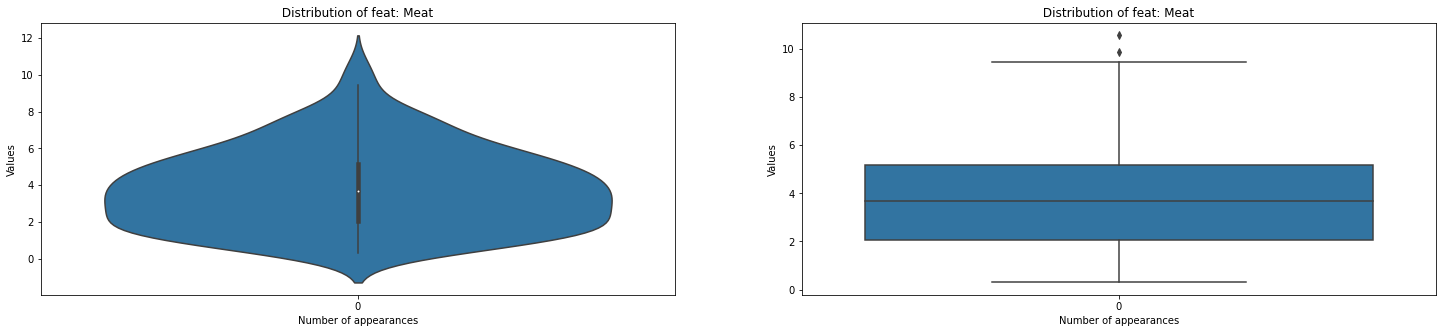

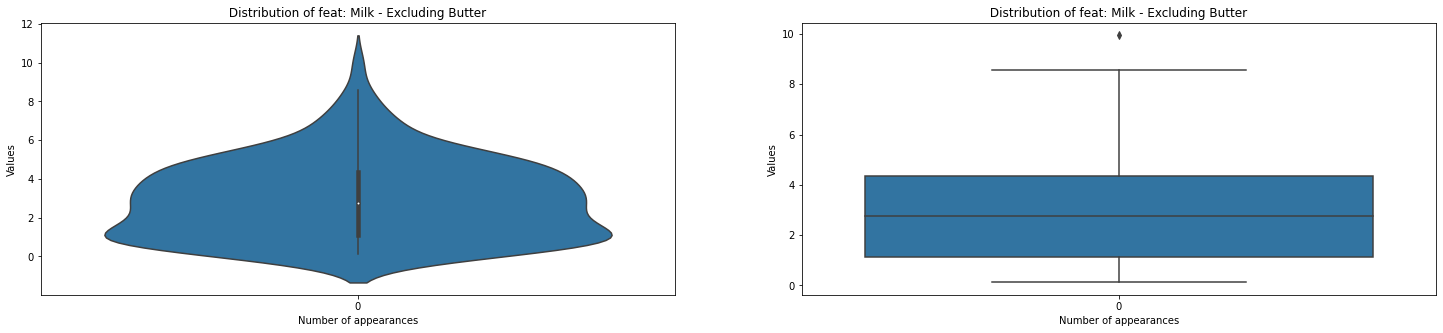

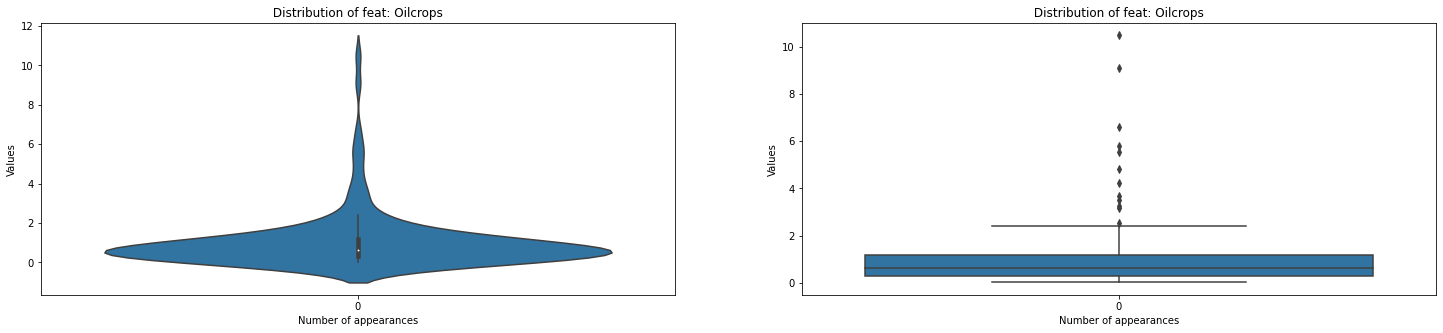

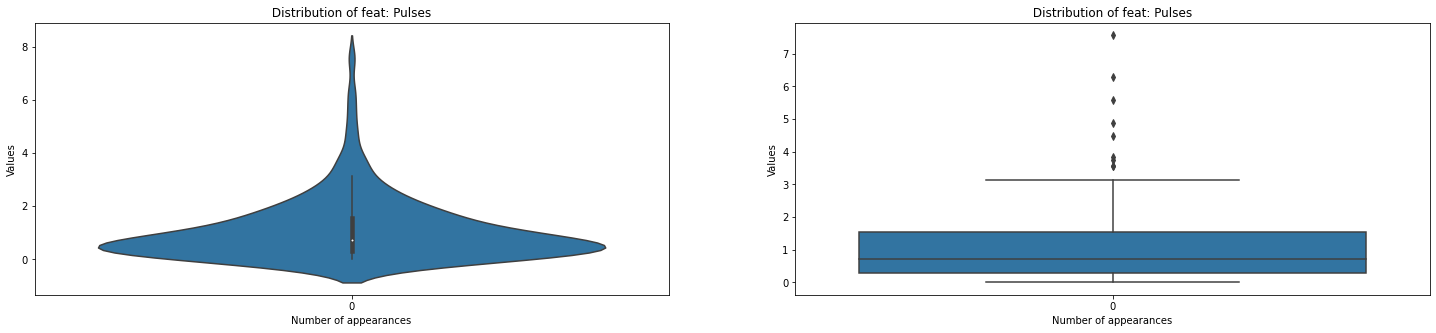

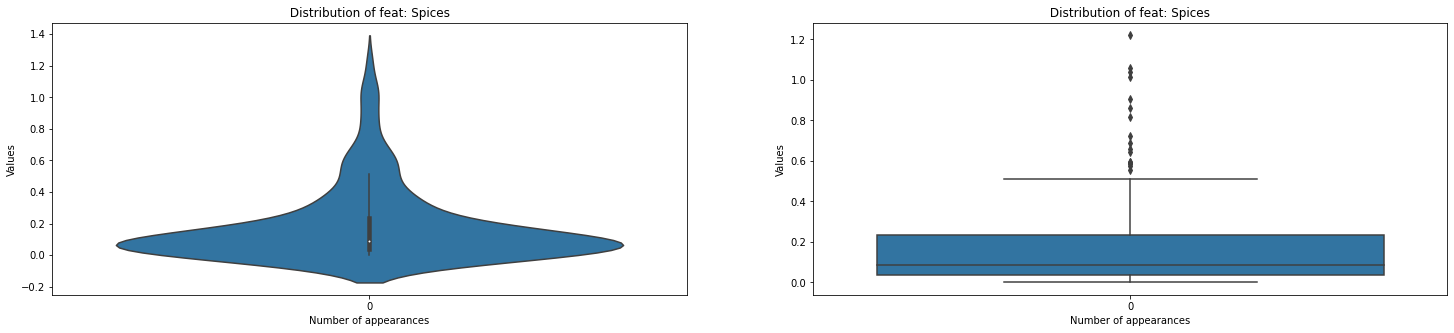

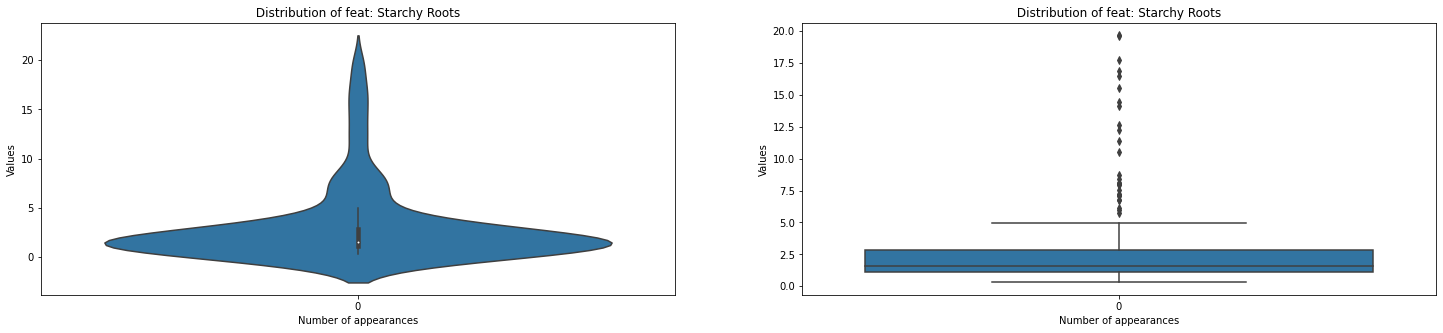

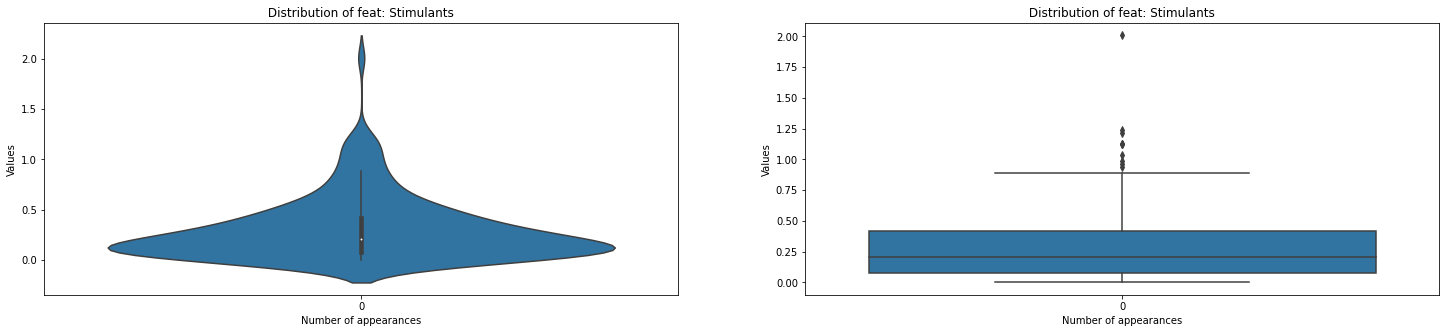

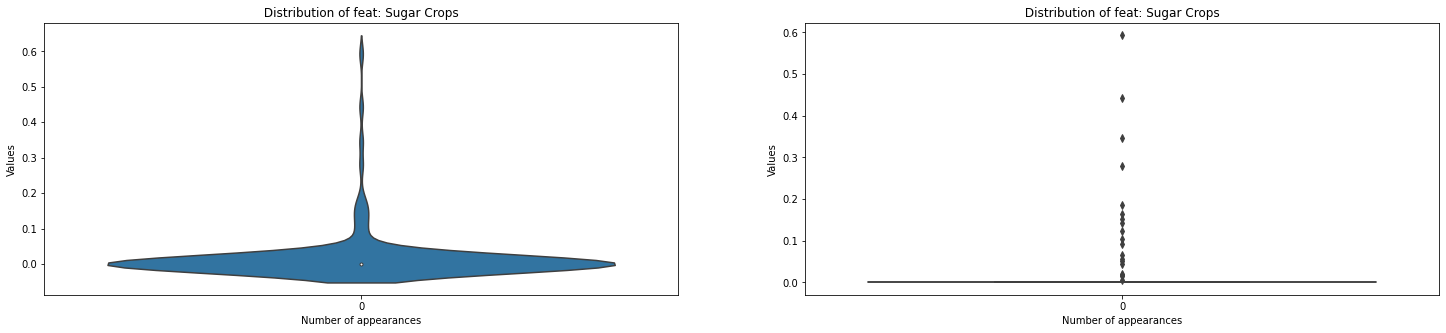

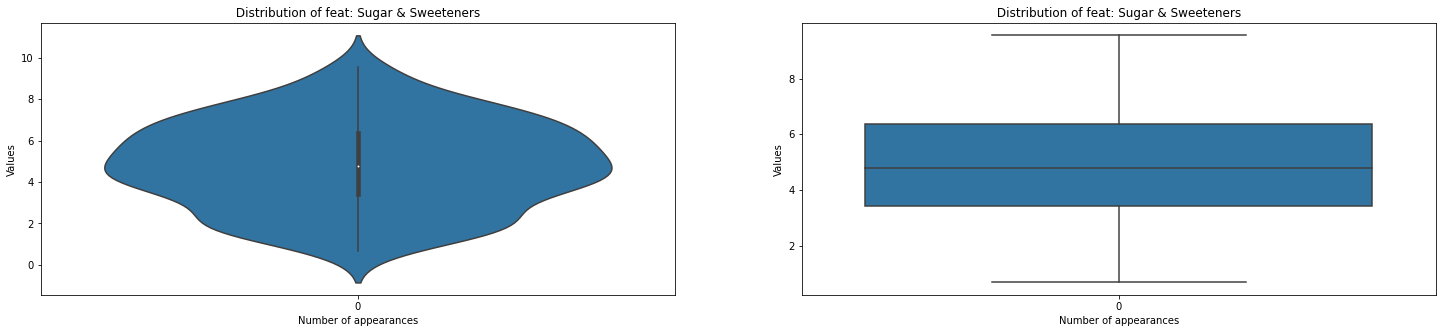

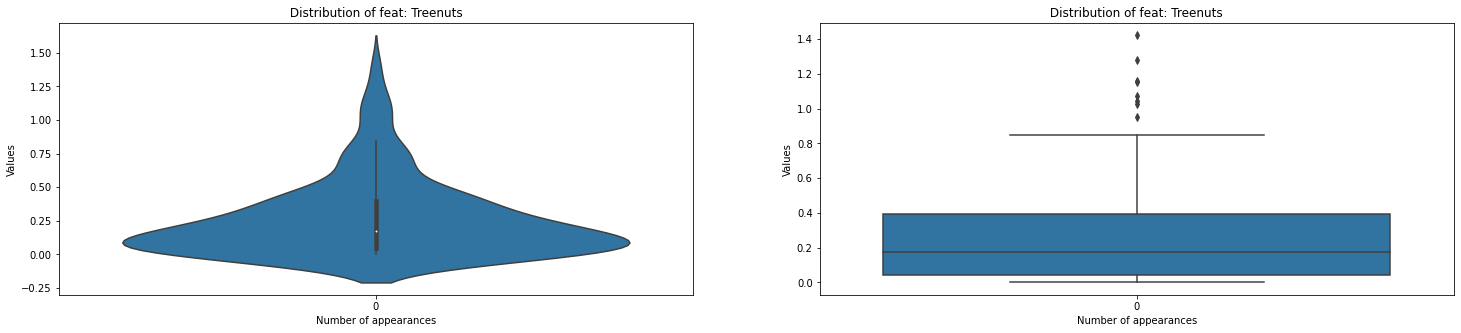

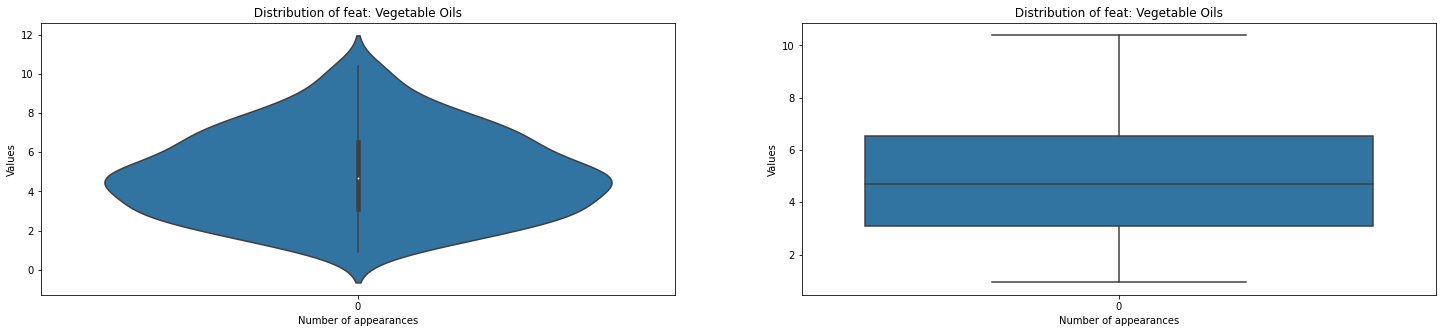

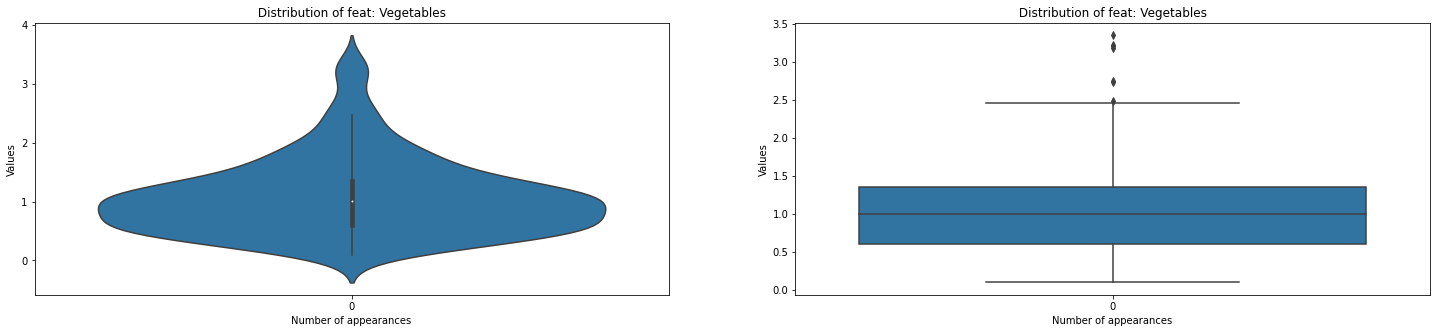

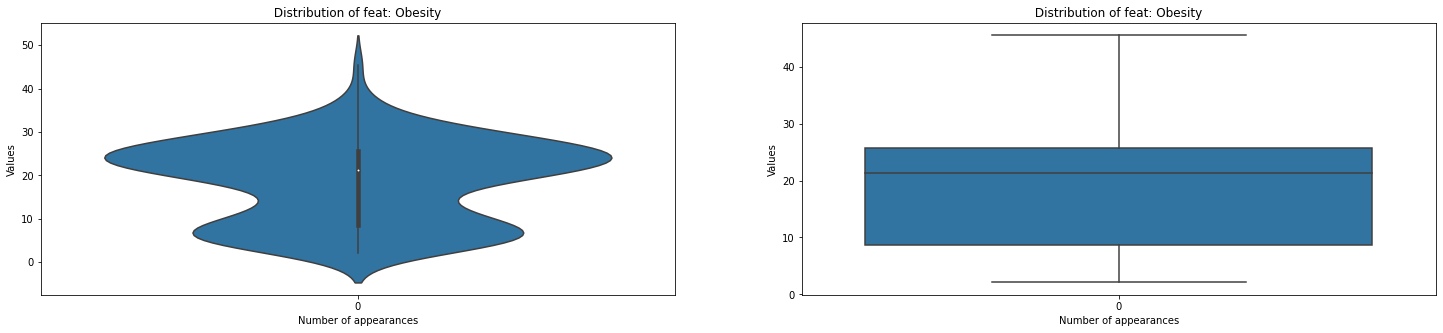

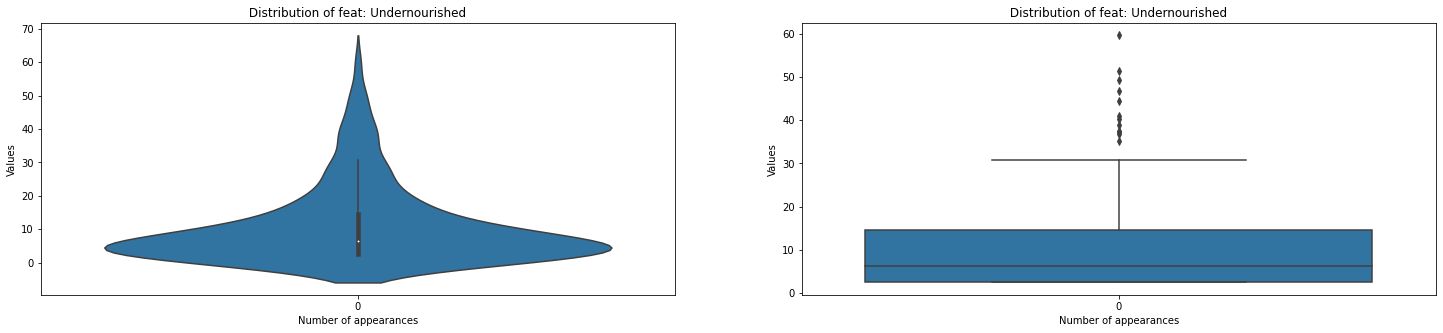

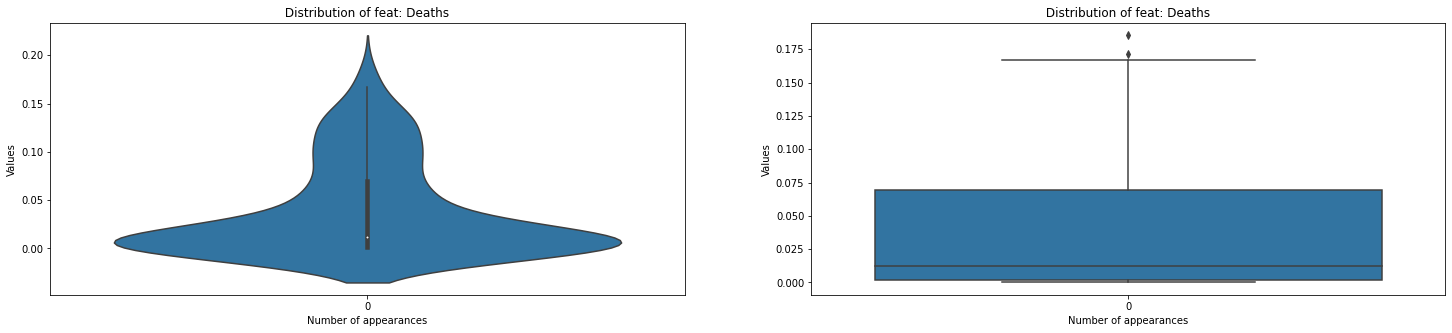

In [ ]:
def sub_and_violin_plots(dataset):
    for feat in dataset.columns[1:].tolist():
        plt.figure(figsize=(25,5))
        plt.subplot(1,2,1)
        ax=sns.violinplot(data=dataset[feat])
        ax.set_title(f" Distribution of feat: {feat} ")
        ax.set_xlabel("Number of appearances")
        ax.set_ylabel("Values")
        plt.subplot(1,2,2)
        bx=sns.boxplot(data=dataset[feat])
        bx.set_title(f" Distribution of feat: {feat} ")
        bx.set_xlabel("Number of appearances")
        bx.set_ylabel("Values")
        plt.show()
      
       

sub_and_violin_plots(dataset)

In [ ]:
dataset['Sugar Crops'].value_counts()

0.0000    145
0.0162      1
0.1847      1
0.4431      1
0.0193      1
0.1051      1
0.0504      1
0.0927      1
0.0557      1
0.0659      1
0.5930      1
0.2793      1
0.0444      1
0.1642      1
0.1233      1
0.1532      1
0.1415      1
0.0052      1
0.0189      1
0.3462      1
Name: Sugar Crops, dtype: int64

Widać że tylko 145/164 krajów wykazuje jakiekolwiek spożycie nieprzetworzonych roślin cukrowych. Pomimo tego, że produkt ten jest spożywany w niewielkiej liczbie krajów, to jednak wciąż może mieć wpływ na zmienną objaśnianą. Zmienna ta zostanie poddana logarytmizacji, aby nieco przybliżyć rozkład do normalnego, choć z oczywistych względów nie uda się całkowicie wyeliminować zaburzeń rozkładu.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


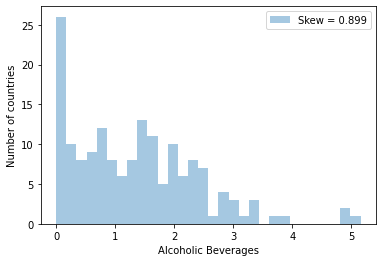

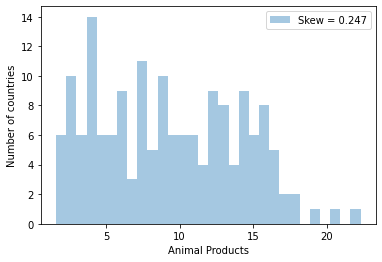

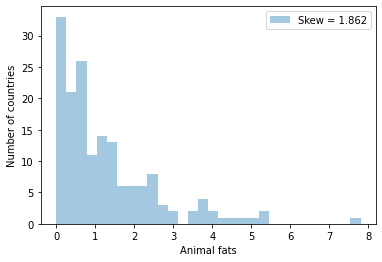

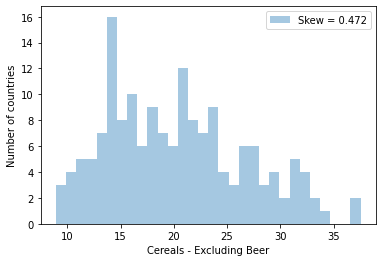

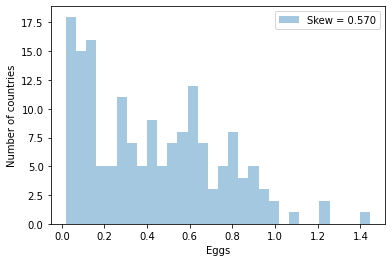

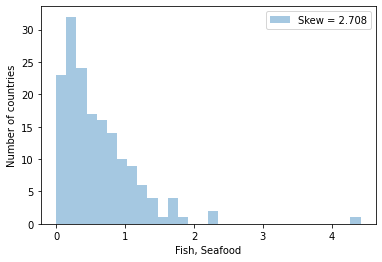

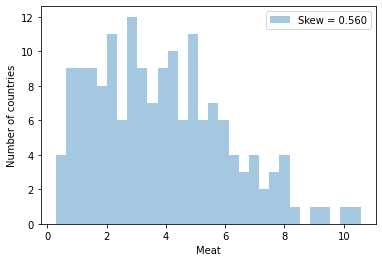

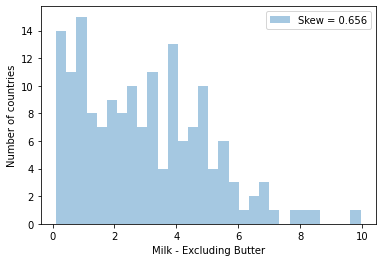

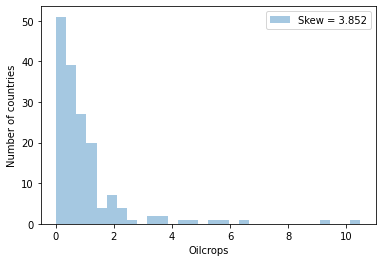

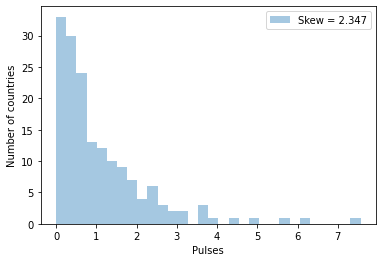

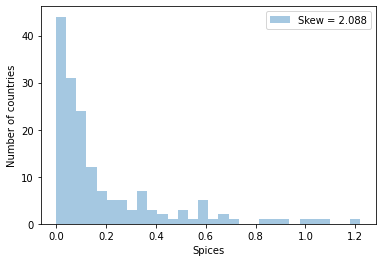

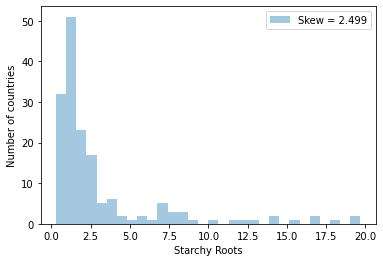

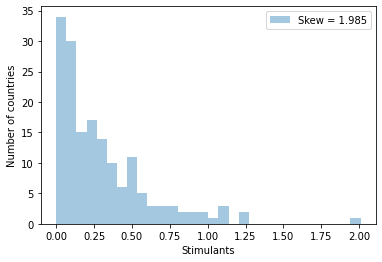

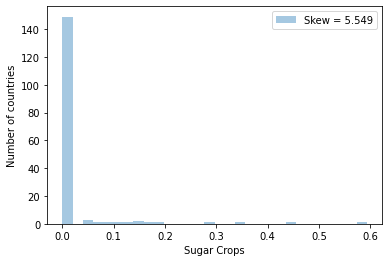

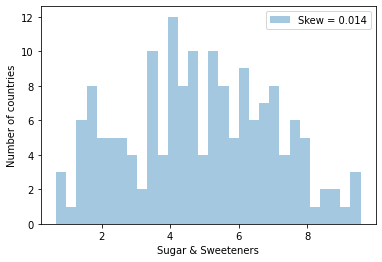

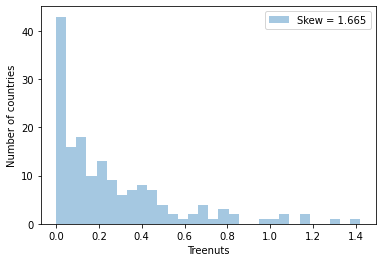

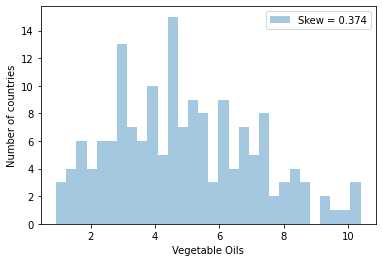

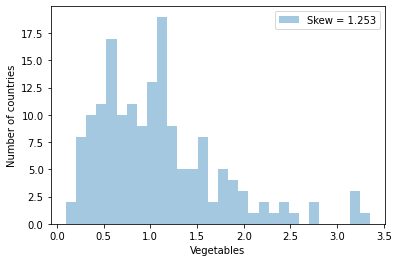

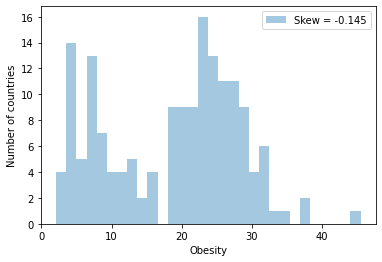

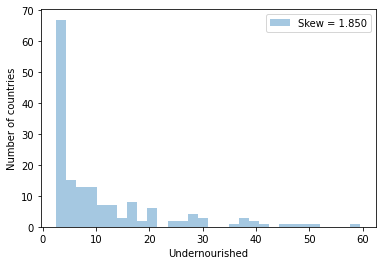

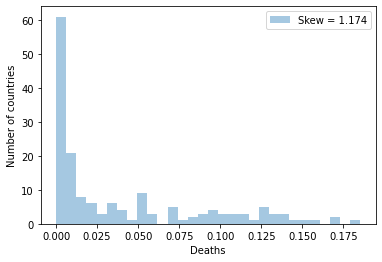

In [ ]:
def check_skewness(dataset):
    for feat in dataset.columns[1:].tolist():
        skew = dataset[feat].skew()
        ax = sns.distplot(dataset[feat],
                     kde=False,
                     label='Skew = %.3f' % (skew),
                     bins=30)
        ax.set(ylabel="Number of countries")
        plt.legend(loc='best')
        plt.show()

check_skewness(dataset)

In [ ]:
from math import log
dataset["alcoholxobesity"] = dataset['Alcoholic Beverages'] * dataset['Obesity']

dataset["Animal_fats_log"] = (dataset['Animal fats']+0.01).apply(lambda x: log(x)) 
dataset["Fish_log"] = (dataset['Fish, Seafood']+0.01).apply(lambda x: log(x))
dataset["Oilcrops_log"] = (dataset['Oilcrops']+0.01).apply(lambda x: log(x)) 
dataset["Pulses_log"] = (dataset['Pulses']+0.01).apply(lambda x: log(x)) 
dataset["Spices_log"] = (dataset['Spices']+0.01).apply(lambda x: log(x)) 
dataset["Starchy_Roots_log"] = (dataset['Starchy Roots']+0.01).apply(lambda x: log(x)) 
dataset["Stimulants_log"] = (dataset['Stimulants']+0.01).apply(lambda x: log(x)) 
dataset["SugarCrops_log"] = (dataset["Sugar Crops"]+0.01).apply(lambda x: log(x)) 
dataset["Treenuts_log"] = (dataset['Treenuts']+0.01).apply(lambda x: log(x)) 
dataset["Vegetables_log"] = (dataset['Vegetables']+0.01).apply(lambda x: log(x))
dataset["Undernourished_log"] = (dataset['Undernourished']+0.01).apply(lambda x: log(x))


Zarówno alkohol jak i otyłość powodują wiele chorób i osłabiają nasz organizm, w związku z tym utworzyliśmy zmienną "alcoholxobesity", która będzie wysoka szczególnie w państwach, w których obydwie cechy przyjmują wysokie wartości.

Kolejne cechy zostały dodane, ponieważ ich wykresy mają duże odstępstwa od rozkładu normalnego, a dzięki ich zlogarytmowaniu zmniejszamy skośność. Jako granicę dla danych wysoce skośnych przyjęta została wartość 1.0 oraz -1.0.

In [ ]:
dataset = dataset.drop(['Animal fats','Fish, Seafood','Oilcrops', 'Pulses', 'Spices', 'Starchy Roots','Stimulants' ,"Sugar Crops",'Treenuts','Vegetables','Undernourished'], axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


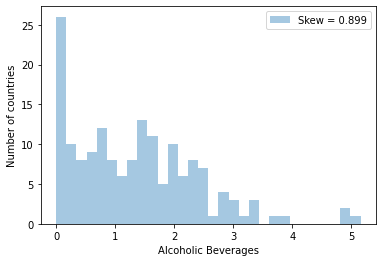

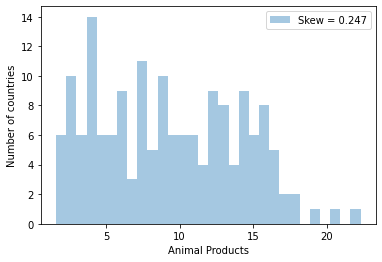

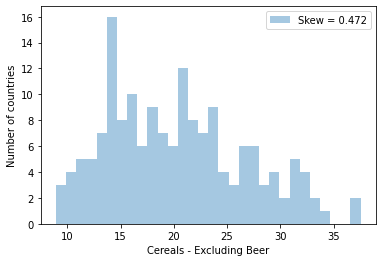

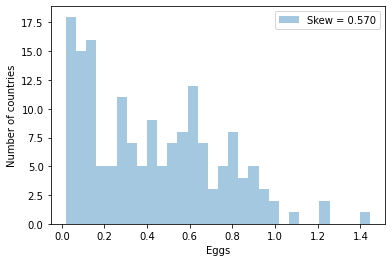

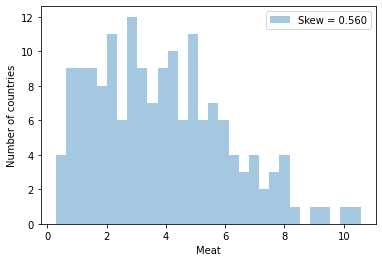

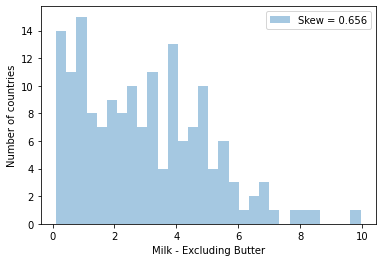

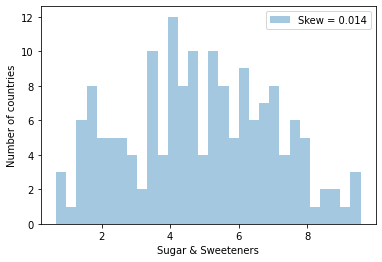

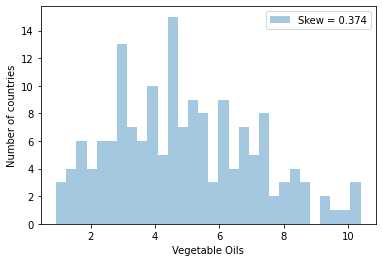

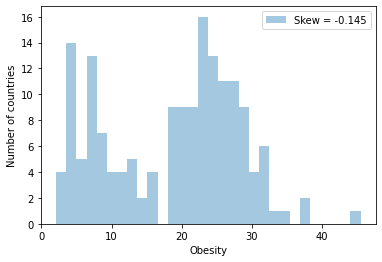

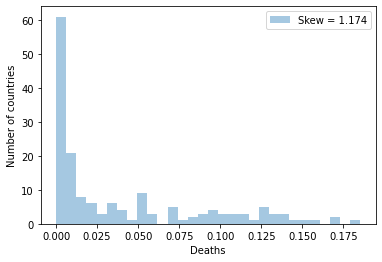

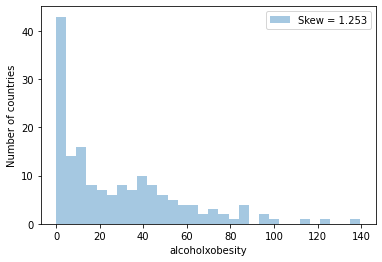

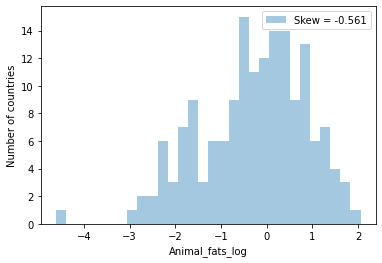

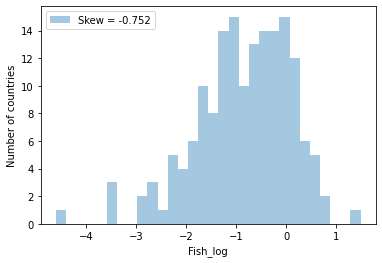

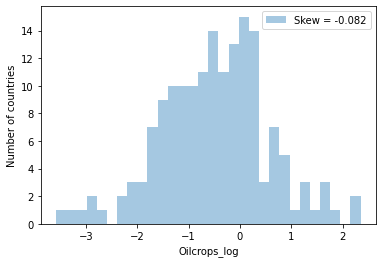

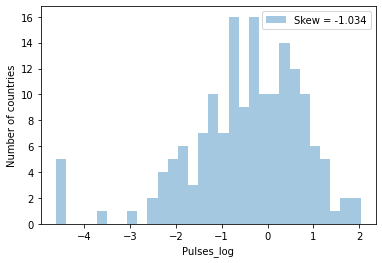

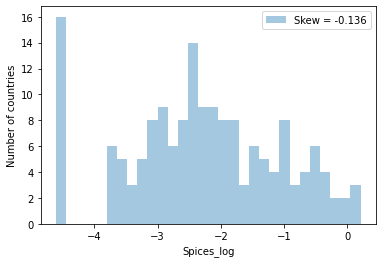

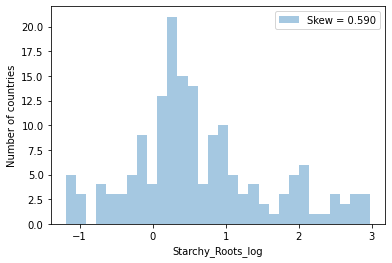

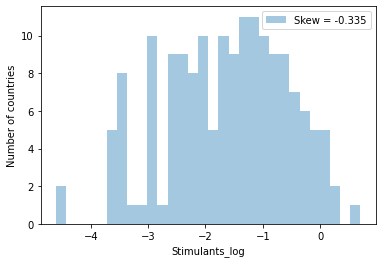

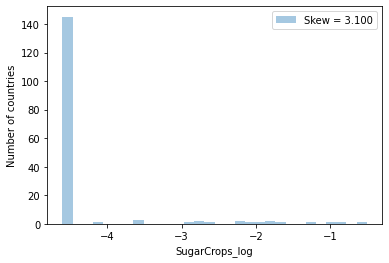

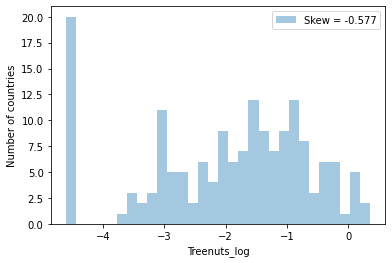

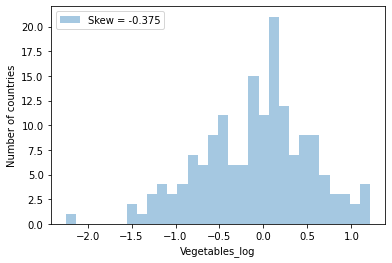

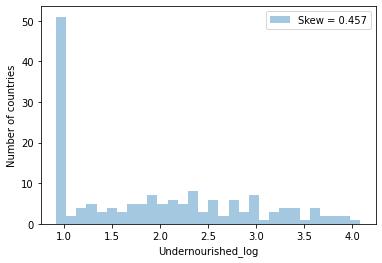

In [ ]:
check_skewness(dataset)

In [ ]:
dataset

,Country,Alcoholic Beverages,Animal Products,Cereals - Excluding Beer,Eggs,Meat,Milk - Excluding Butter,Sugar & Sweeteners,Vegetable Oils,Obesity,Deaths,alcoholxobesity,Animal_fats_log,Fish_log,Oilcrops_log,Pulses_log,Spices_log,Starchy_Roots_log,Stimulants_log,SugarCrops_log,Treenuts_log,Vegetables_log,Undernourished_log
0,Afghanistan,0.0000,4.7774,37.1186,0.1501,1.2006,2.4512,2.2261,2.3012,4.5,0.006186,0.00000,-0.150358,-4.605170,-1.686859,-0.672756,-2.206366,-1.093028,-2.465104,-4.605170,-2.001740,-0.273911,3.394844
1,Albania,0.9120,16.0930,16.2107,0.8091,3.8688,9.9441,3.4422,2.8244,22.3,0.050951,20.33760,0.066817,-1.850873,0.094037,-0.199549,-4.605170,0.243025,-1.346689,-4.605170,-0.898451,1.015520,1.826161
2,Algeria,0.0896,6.0326,25.0112,0.4181,1.2543,3.9869,3.9869,5.7638,26.6,0.006558,2.38336,-1.589145,-2.044074,-1.277261,0.095310,-2.044074,0.660727,-1.836966,-4.605170,-1.452434,0.720616,1.363537
3,Angola,1.9388,4.6927,18.3521,0.0441,2.9302,0.5067,2.7539,4.2741,6.8,0.001461,13.18384,-1.293168,-0.165818,0.085719,0.410851,-4.605170,2.536384,-2.916921,-4.605170,-4.605170,-1.014731,3.219276
4,Antigua and Barbuda,2.3041,15.3672,13.7215,0.2057,7.0356,4.6904,5.8218,4.6904,19.1,0.007143,44.00831,0.440124,0.552735,-0.499886,-0.770893,-1.022485,-0.158527,-0.685774,-4.605170,-2.382711,0.266969,0.920283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,Venezuela (Bolivarian Republic of),0.8454,7.2303,21.3126,0.2892,3.1368,2.6474,7.7864,7.5417,25.2,0.004287,21.30408,-0.493149,-0.787678,-2.909555,-0.295580,-4.605170,0.312692,-2.567854,-4.605170,-4.605170,-0.389493,3.054473
160,Vietnam,0.7150,10.9806,26.9833,0.2894,7.8311,0.5618,2.0940,1.3279,2.1,0.000036,1.50150,-0.055196,0.047361,0.641696,-0.755661,-0.831031,-0.321584,-2.188364,-1.812779,-1.001032,0.676916,2.231089
161,Yemen,0.0000,3.4667,32.0727,0.1455,2.0121,0.6545,7.0303,3.9515,14.1,0.002062,0.00000,-1.051538,-1.716466,-1.716466,0.200571,-2.838729,-1.123315,-2.031032,-4.605170,-3.375530,-0.984570,3.661251
162,Zambia,1.1925,3.3043,31.5528,0.1988,1.5155,0.5217,2.5590,3.0062,6.5,0.004564,7.75125,-1.099613,-0.542316,1.160052,-1.177331,-2.471004,1.413277,-3.358138,-4.605170,-4.605170,-0.782634,3.843958


Dla zbioru po przekształceniach wykonana zostanie jeszcze raz macierz korelacji aby zaobserwować które cechy teraz są najbardziej skorelowane ze zmienną objaśnianą.

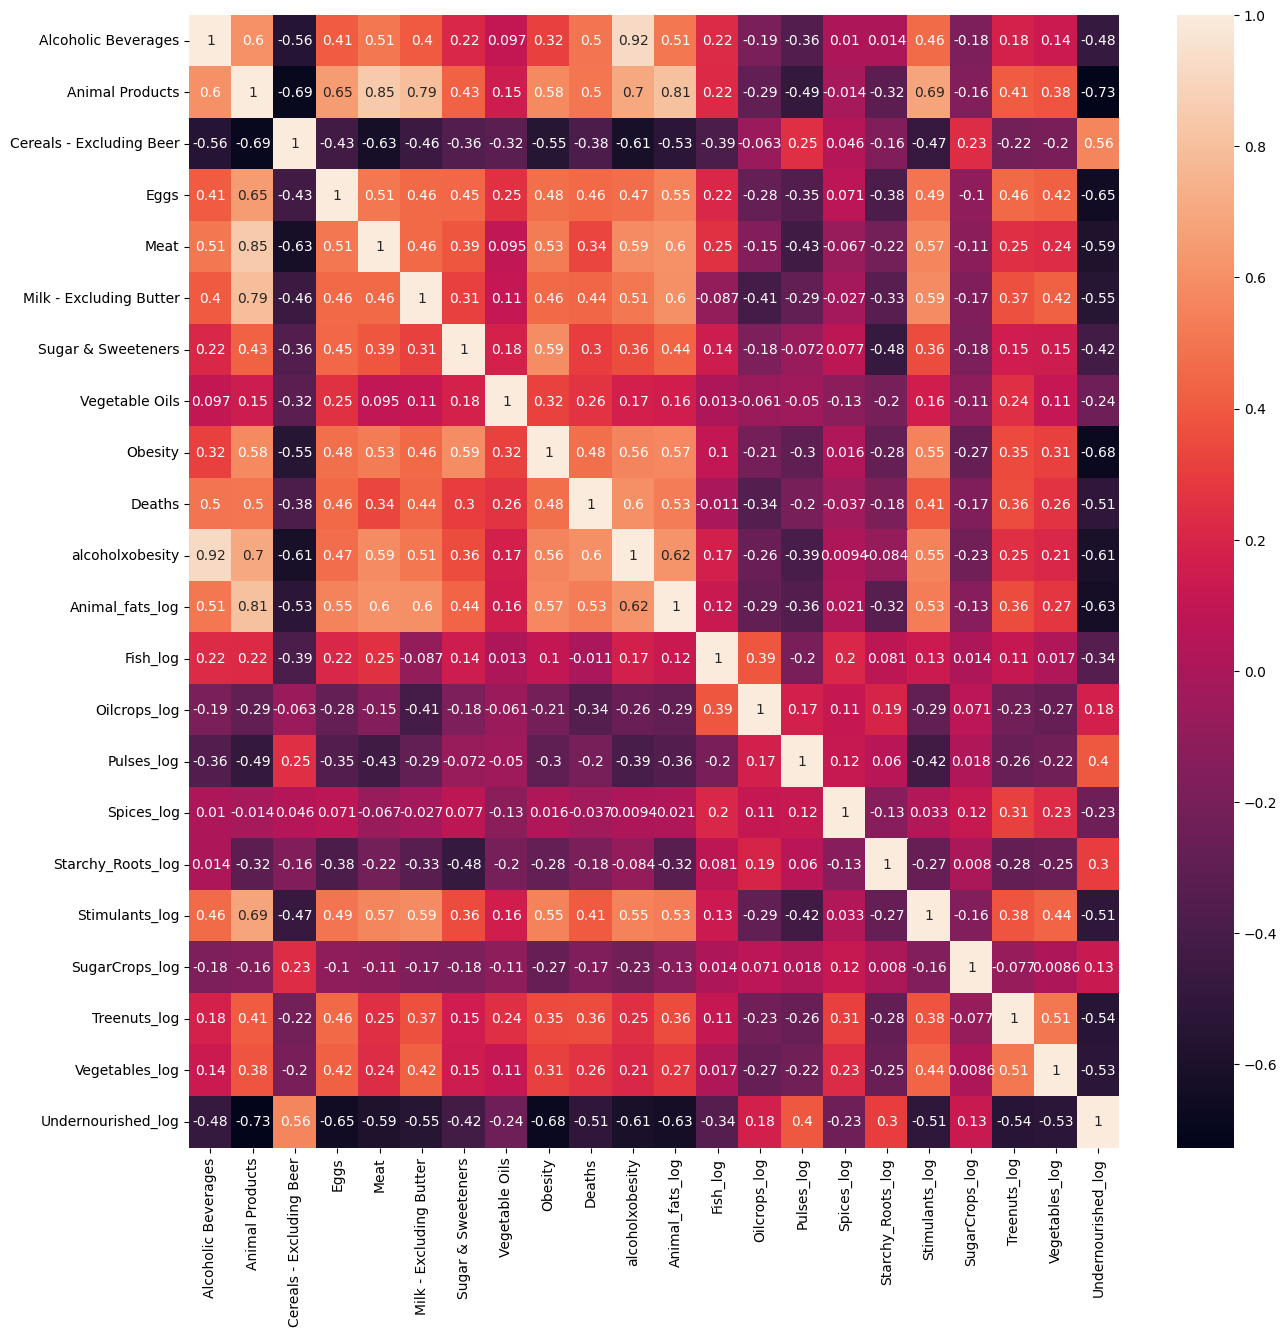

In [ ]:
corr_heatmap = dataset.corr()
plt.figure(figsize=(15, 15), dpi=100)
sns.heatmap(corr_heatmap, annot=corr_heatmap)

Według niej najbardziej przydatne dla regresji liniowej owinny być zmienne:

* Undernourished_log
* Stimulants_log
* Animal_fats_log
* alcoholobesity (również obesity oraz alcohol beverages)
* Milk
* Eggs
* Animal Products

# Hipoteza badawcza

Postawiono następujące hipotezy badawcze:

* Niezdrowe odżywianie mieszkańców danego kraju (spożycie dużej ilości tłuszczy zwierzęcych, napojów alkoholowych, słodyczy) wpływa na większą śmiertelność chorych na COVID-19 w tym kraju.

* Większy stosunek osób otyłych względem całej populacji danego kraju zwiększa śmiertelność chorych na COVID-19 w tym kraju.

* W krajach w których jest bardziej powszechne niedożywienie występuje większa śmiertelność chorych na COVID-19.


W ramach poniższej analizy nastąpi próba potwierdzenia bądź obalenia powyższych hipotez. Jednocześnie nie zakładamy że model będzie ,,idealnie'' przewidywał śmiertelność na COVID-19 w danym kraju. Zmienna ta zależy bowiem od takich czynników jak przyjęta w danym kraju strategia walki z pandemią czy infrastruktury zdrowotnej. Głównym celem badania jest stwierdzenie czy zależność między odżywianiem a śmiertelnością na COVID-19 populacji kraju w ogólne istnieje.

## Wybór najlepszych cech 

Dobór cech został przeprowadzony za pomocą metod - Lasso, RFE z pakietu sklearn, oraz własnoręcznie zaimplementowaną regresją wstecz.

### 1. Metoda Lasso ###

In [ ]:
X = dataset.drop(['Deaths'], axis=1)
y = dataset['Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_train_countries_names, X_test_countries_names = X_train, X_test

X_train = X_train.drop(['Country'], axis=1)
X_test = X_test.drop(['Country'], axis=1)

Na początku dzielimy zbiór na treningowy i testowy w proporcjach 80:20

In [ ]:
model_lasso = linear_model.Lasso(alpha=0.001) 
model_lasso.fit(X_train , y_train )
print("Lizba iteracji metody" , model_lasso.n_iter_)

Lizba iteracji metody 57


In [ ]:
features = X_train.columns
support = [abs(coef)>0 for coef in model_lasso.coef_]
lasso_features = np.array(features)[support]
print(lasso_features)

['Animal Products' 'Eggs' 'Meat' 'Sugar & Sweeteners' 'Vegetable Oils'
 'Obesity' 'alcoholxobesity' 'Animal_fats_log' 'Fish_log' 'Oilcrops_log'
 'Pulses_log' 'Spices_log' 'Stimulants_log' 'Treenuts_log'
 'Undernourished_log']


Można zaobserwować że metoda lasso wybiera zmienne, które również w macierzy korelacji miały większe wartości korelacji liniowej ze zmienną Deaths, a wyrzuca te które dawały małe korelacje np. fish_log (korelacja = -0.011) czy Spices_log (korelacja = -0.037).

### 2 Regresja krokowa w tył

In [ ]:
#Wybór cech za pomocą regresji krokowej w tył
lr = LinearRegression()
features =  list(X_train.columns.values)
n=0
errors_and_features={}

while len(features) > 3:
    to_delete=features[0]
    error_after_deleting = 1e20
    n+=1
    for delete in features:
        temp_features=features.copy()
        temp_features.remove(delete)
        scores = cross_validate(lr,X_train[temp_features],y_train,scoring='neg_mean_squared_error', cv=10)
        error = -scores['test_score'].mean()
        if error < error_after_deleting:
            error_after_deleting = error
            to_delete = delete
    features.remove(to_delete)
    errors_and_features[error_after_deleting]=str(features)
    print(f"MSE = {error_after_deleting} after deleting {n} features {features}")


MSE = 0.0016682302429284362 after deleting 1 features ['Alcoholic Beverages', 'Cereals - Excluding Beer', 'Eggs', 'Meat', 'Milk - Excluding Butter', 'Sugar & Sweeteners', 'Vegetable Oils', 'Obesity', 'alcoholxobesity', 'Animal_fats_log', 'Fish_log', 'Oilcrops_log', 'Pulses_log', 'Spices_log', 'Starchy_Roots_log', 'Stimulants_log', 'SugarCrops_log', 'Treenuts_log', 'Vegetables_log', 'Undernourished_log']
MSE = 0.0016107139173124768 after deleting 2 features ['Alcoholic Beverages', 'Cereals - Excluding Beer', 'Eggs', 'Meat', 'Milk - Excluding Butter', 'Sugar & Sweeteners', 'Vegetable Oils', 'Obesity', 'alcoholxobesity', 'Animal_fats_log', 'Fish_log', 'Oilcrops_log', 'Pulses_log', 'Starchy_Roots_log', 'Stimulants_log', 'SugarCrops_log', 'Treenuts_log', 'Vegetables_log', 'Undernourished_log']
MSE = 0.0015704063014877223 after deleting 3 features ['Alcoholic Beverages', 'Cereals - Excluding Beer', 'Eggs', 'Meat', 'Milk - Excluding Butter', 'Vegetable Oils', 'Obesity', 'alcoholxobesity', 'An

In [ ]:
best = min(errors_and_features)
print(f"best error is equal {best} with features {errors_and_features[best]}")

best error is equal 0.0014301577148564172 with features ['Cereals - Excluding Beer', 'Eggs', 'Meat', 'alcoholxobesity', 'Animal_fats_log', 'Fish_log', 'Treenuts_log']


In [ ]:
best_features=['Cereals - Excluding Beer', 'Eggs', 'Meat', 'alcoholxobesity', 'Animal_fats_log', 'Fish_log', 'Treenuts_log']
backward_features  = np.array(best_features)

Można dostrzec że metoda wyboru krokowego wstecz wybiera jako najlepszy zestaw cech zmienne które znajdowały się również w zestwie wybranym przez LASSO, poprostu jest ich mniej. Jedyną ciekawą cechą jest Cereals - Excluding Beer. Została ona wybrana przez regresję wstecz, jednak nie przez LASSO (pomimo że alpha w metodzie LASSO została ustawiona celowo na wartość niską, aby wykryć wszystkie przydatne cechy). Może to wynikać z faktu że LASSO wyzerowało współczynnik dla tej zmiennej jako skorelowany z inną zmienną (patrząc na macierz korelacji widzimy że dla tej zmiennej korelacje z innymi zmeinnymi są dość duże np. z alcoholobesity, meat , które zostają wybrane przez LASSO).

# Opracowanie modelu

## 1. Model regresji liniowej dla cech wybranych przez Lasso 

In [ ]:
reg1 = LinearRegression()
reg1.fit(X_train[lasso_features], y_train)
results_reg1 = cross_val_score(reg1, X_train[lasso_features], y_train, cv=10, scoring='neg_mean_squared_error')

In [ ]:
print("MSE przy walidacdji krzyżowej dla modelu regresji liniowej dla cech wybranych przez LASSO", np.abs(np.mean(results_reg1)))

MSE przy walidacdji krzyżowej dla modelu regresji liniowej dla cech wybranych przez LASSO 0.0016051480312650073


## 2. Model regresji grzbietowej dla cech wybranych przez Lasso

In [ ]:
lambdas =  [0.01, 0.1,0.2, 0.5,0.8, 1, 2,5, 10,15, 30, 100]
mse_per_lambda = []


for lamb in lambdas:
    clf = Ridge(alpha=lamb)
    scores = cross_val_score(clf, X_train[lasso_features], y_train, cv=10, scoring='neg_mean_squared_error')
    mse_per_lambda.append(np.abs(np.mean(scores)))
    clf.fit(X_train,y_train)

for i in range(len(lambdas)):
    print(f"MSE dla lambda = {lambdas[i]} oraz cech wybranych przez Lasso:", mse_per_lambda[i])

MSE dla lambda = 0.01 oraz cech wybranych przez Lasso: 0.001604928157870672
MSE dla lambda = 0.1 oraz cech wybranych przez Lasso: 0.0016030033894687326
MSE dla lambda = 0.2 oraz cech wybranych przez Lasso: 0.0016009718918184076
MSE dla lambda = 0.5 oraz cech wybranych przez Lasso: 0.00159545984187573
MSE dla lambda = 0.8 oraz cech wybranych przez Lasso: 0.0015906605094468764
MSE dla lambda = 1 oraz cech wybranych przez Lasso: 0.0015877773478597315
MSE dla lambda = 2 oraz cech wybranych przez Lasso: 0.0015760118058732423
MSE dla lambda = 5 oraz cech wybranych przez Lasso: 0.0015533928749204638
MSE dla lambda = 10 oraz cech wybranych przez Lasso: 0.0015301367268618635
MSE dla lambda = 15 oraz cech wybranych przez Lasso: 0.0015139585703102029
MSE dla lambda = 30 oraz cech wybranych przez Lasso: 0.0014842299194362447
MSE dla lambda = 100 oraz cech wybranych przez Lasso: 0.001452221028681699


In [ ]:
reg2 = Ridge(alpha =100)
reg2.fit( X_train[lasso_features], y_train)
results_reg2 = cross_val_score(reg2,  X_train[lasso_features], y_train, cv=10, scoring='neg_mean_squared_error')
print("MSE przy walidacji krzyżowej dla modelu RIDGE Regression dla cech wybranych przez LASSO", np.abs(np.mean(results_reg2)))

MSE przy walidacji krzyżowej dla modelu RIDGE Regression dla cech wybranych przez LASSO 0.001452221028681699


### 3. Model regresji grzbietowej dla cech wybranych metodą propagacji wstecz

In [ ]:
lambdas =  [0.01, 0.1,0.2, 0.5,0.8, 1, 2,4,5,6,7, 10,15, 30, 100]

for i in lambdas: 
    reg3 = Ridge(alpha = i)
    reg3.fit(X_train[backward_features], y_train)
    results_reg3 = cross_val_score(reg3,  X_train[backward_features], y_train, cv=10, scoring='neg_mean_squared_error')
    print(f"MSE dla lambda ={i} oraz cech wybranych regresją krokową wstecz", np.abs(np.mean(results_reg3)))

reg3 = Ridge(alpha=2)
reg3.fit(X_train[backward_features], y_train)

MSE dla lambda =0.01 oraz cech wybranych regresją krokową wstecz 0.0014300851622103597
MSE dla lambda =0.1 oraz cech wybranych regresją krokową wstecz 0.0014294644455180587
MSE dla lambda =0.2 oraz cech wybranych regresją krokową wstecz 0.0014288388019469654
MSE dla lambda =0.5 oraz cech wybranych regresją krokową wstecz 0.0014273109831148178
MSE dla lambda =0.8 oraz cech wybranych regresją krokową wstecz 0.0014262091616278052
MSE dla lambda =1 oraz cech wybranych regresją krokową wstecz 0.0014256614335222157
MSE dla lambda =2 oraz cech wybranych regresją krokową wstecz 0.0014244148770160762
MSE dla lambda =4 oraz cech wybranych regresją krokową wstecz 0.0014253144730764582
MSE dla lambda =5 oraz cech wybranych regresją krokową wstecz 0.001426306782197534
MSE dla lambda =6 oraz cech wybranych regresją krokową wstecz 0.0014273695426984035
MSE dla lambda =7 oraz cech wybranych regresją krokową wstecz 0.0014284216646383147
MSE dla lambda =10 oraz cech wybranych regresją krokową wstecz 0.0

Ridge(alpha=2)

### 4. Model regresji grzbietowej dla różnych parametrów lambda oraz cech wybieranych metodą RFE

In [ ]:
lr = LinearRegression()
for i in [3,4,5,6,7,8,9]:
    features=(X_train.columns.values)
    selector = RFE(lr, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, y_train)

    chosen_features=features[selector.support_]
    print(chosen_features)
    lambdas =  [0.01, 0.1,0.2, 0.5,0.8, 1, 2,4,5,6,7, 10,15, 30, 100]
    best_score=1e20
    best_lamda=lambdas[0]

    for j in lambdas: 
        reg4 = Ridge(alpha = j)
        reg4.fit( X_train[chosen_features], y_train)
        results_reg4 = cross_val_score(reg4,  X_train[chosen_features], y_train, cv=10, scoring='neg_mean_squared_error')
        if np.abs(np.mean(results_reg4)) < best_score:
            best_score=np.abs(np.mean(results_reg4))
            best_lambda=j
    print(f"MSE dla lambda ={best_lambda} oraz cech wybranych regresją krokową wstecz", np.abs(np.mean(results_reg4)))


['Alcoholic Beverages' 'Eggs' 'Animal_fats_log']
MSE dla lambda =2 oraz cech wybranych regresją krokową wstecz 0.0017046859499926087
['Alcoholic Beverages' 'Eggs' 'Animal_fats_log' 'Oilcrops_log']
MSE dla lambda =4 oraz cech wybranych regresją krokową wstecz 0.0016515424029131538
['Alcoholic Beverages' 'Eggs' 'Animal_fats_log' 'Oilcrops_log'
 'Treenuts_log']
MSE dla lambda =15 oraz cech wybranych regresją krokową wstecz 0.001553275237968223
['Alcoholic Beverages' 'Eggs' 'Animal_fats_log' 'Oilcrops_log'
 'Pulses_log' 'Treenuts_log']
MSE dla lambda =15 oraz cech wybranych regresją krokową wstecz 0.0015695550428693698
['Alcoholic Beverages' 'Eggs' 'Animal_fats_log' 'Oilcrops_log'
 'Pulses_log' 'Treenuts_log' 'Undernourished_log']
MSE dla lambda =30 oraz cech wybranych regresją krokową wstecz 0.0015335539724838827
['Alcoholic Beverages' 'Eggs' 'Animal_fats_log' 'Oilcrops_log'
 'Pulses_log' 'Spices_log' 'Treenuts_log' 'Undernourished_log']
MSE dla lambda =30 oraz cech wybranych regresją kro

**Podsumowanie modeli:**

**1. Model regresji liniowej dla cech wybranych przez LASSO (15 cech)**

* Wynik MSE walidacji: 0.001605

**2. Model Ridge dla cech wybranych przez LASSO (15 cech)**

* Wynik MSE walidacji: 0.001452
* Najlepsza lambda: 100

Cechy dla modeli 1 i 2:  'Animal Products' 'Eggs' 'Meat' 'Sugar & Sweeteners' 'Vegetable Oils'
 'Obesity' 'alcoholxobesity' 'Animal_fats_log' 'Fish_log' 'Oilcrops_log'
 'Pulses_log' 'Spices_log' 'Stimulants_log' 'Treenuts_log'
 'Undernourished_log'

**3. Model Ridge dla cech wybranych metodą propagacji wstecz**

* Wynik MSE walidacji: 0.001424
* Najlepsza lambda: 2

Cechy dla modelu 3: 'Cereals - Excluding Beer', 'Eggs', 'Meat', 'alcoholxobesity', 'Animal_fats_log', 'Fish_log', 'Treenuts_log'

**4. Model Ridge dla różnych parametrów lambda oraz cech wybieranych metodą RFE**

* Wynik MSE walidacji: 0.001528
* Najlepsza lambda: 30

Cechy dla modelu 4: 'Alcoholic Beverages' 'Eggs' 'Meat' 'Animal_fats_log' 'Oilcrops_log'
 'Pulses_log' 'Spices_log' 'Treenuts_log' 'Undernourished_log'

Walidację przeprowadzano za pomocą walidacji krzyżowej z podziałem próby na 10 podzbiorów. Teoretycznie nasz najlepszy model to Model Ridge dla cech wybranych metodą propagacji wstecz. Jednak nie zawiera on wszystkich cech które są nam potrzebne do sprawdzenia hipotez badawczych. Dlatego jako końcowe modele wybieramy dwa modele -Model Ridge dla cech wybranych przez Lasso, czyli z 15 cechami - Oraz model Model Ridge dla 7 cech wybranych metodą propagacji wstecz. 


# Interpretacja końcowego modelu

Na podstawie walidacji krzyżowej kilku konkurencyjnych modeli tworzonych dla różnych współczynników regularyzacji oraz zestwów cech, wybrane zostały dwa finalne modele, odpowiednio dla 7 wybranych poprzez regresję wsteczną oraz 15 wybranych poprzez regresję LASSO. Modele te posłużą do weryfikacji hipotezy badawczej.

In [ ]:
final_model = reg3

mse_train = mean_squared_error(final_model.predict(X_train[backward_features]), y_train)
mse_test = mean_squared_error(final_model.predict(X_test[backward_features]), y_test)
print("MSE dla danych treningowych", mse_train)
print("MSE dla danych testowych",  mse_test)
print("Różnice dla MSE train i test", mse_train-mse_test)

MSE dla danych treningowych 0.0012884441698164553
MSE dla danych testowych 0.0011555323418536193
Różnice dla MSE train i test 0.00013291182796283598


In [ ]:
r2_train = final_model.score(X_train[backward_features], y_train)
r2_test = final_model.score(X_test[backward_features], y_test)
adj_r2_train = 1 - ((1 - r2_train) * (len(X_train) - 1) / (len(X_train) - len(backward_features)  - 1))
adj_r2_test = 1 - ((1 - r2_test) * (len(X_test) - 1) / (len(X_test) - len(backward_features)  - 1))

print("Współczynnik determinacji r-squared dla danych treningowych", r2_train)
print("Współczynnik determinacji r-squared dla danych testowych", r2_test)

Współczynnik determinacji r-squared dla danych treningowych 0.478999723794854
Współczynnik determinacji r-squared dla danych testowych 0.3931804135531055


In [ ]:
print("Dla modelu z 7 cechami otrzymano poszczególne oszacowania parametrów:")
for i in range (len(backward_features)):
  print(backward_features[i], ":", final_model.coef_[i])

Dla modelu z 7 cechami otrzymano poszczególne oszacowania parametrów:
Cereals - Excluding Beer : -0.0006274655023785986
Eggs : 0.02749203287106579
Meat : -0.004877295608818489
alcoholxobesity : 0.0007539187383428075
Animal_fats_log : 0.008877163862497954
Fish_log : -0.006132653902344215
Treenuts_log : 0.006082472762296733



Współczynnik determinacji R² informuje o tym, jaka część wariancji zmiennej objaśnianej w próbie jest wyjaśniona zmiennymi zawartymi w modelu. Jest on więc miarą stopnia, w jakim model pasuje do próby. Otrzymany finalny model wyjaśnia więc ok 39% wariancji śmiertelności na chorobę COVID-19 danego kraju z danych testowych.

In [ ]:
final_model = reg2

mse_train = mean_squared_error(final_model.predict(X_train[lasso_features]), y_train)
mse_test = mean_squared_error(final_model.predict(X_test[lasso_features]), y_test)
print("MSE dla danych treningowych", mse_train)
print("MSE dla danych testowych",  mse_test)
print("Różnice dla MSE train i test", mse_train-mse_test)

MSE dla danych treningowych 0.001271144581506839
MSE dla danych testowych 0.0009856369688183721
Różnice dla MSE train i test 0.00028550761268846697


In [ ]:
r2_train = final_model.score(X_train[lasso_features], y_train)
r2_test = final_model.score(X_test[lasso_features], y_test)
adj_r2_train = 1 - ((1 - r2_train) * (len(X_train) - 1) / (len(X_train) - len(lasso_features)  - 1))
adj_r2_test = 1 - ((1 - r2_test) * (len(X_test) - 1) / (len(X_test) - len(lasso_features)  - 1))

print("Współczynnik determinacji r-squared  dla danych treningowych", r2_train)
print("Współczynnik determinacji r-squared  dla danych testowych", r2_test)

Współczynnik determinacji r-squared  dla danych treningowych 0.4859950523458998
Współczynnik determinacji r-squared  dla danych testowych 0.4823997597110079


Drugi model z 15 cechami, choć otrzymywał gorsze wyniki przy walidacji krzyżowej, końcowo dla danych testowych przejawia niższą wartość błędu MSE dla danych testowych 0.00098, przy 0.00115 dla modelu z 7 cechami. Jednocześnie model ten wyjaśnia więc ok 48% wariancji śmiertelności na chorobę COVID-19 danego kraju z danych testowych, współczynnik determinacji jest jednak wrażliwy na wzrost liczby zmiennych modelu, nie musi więc to świadczyć o wyższej jakości modelu.

In [ ]:
 preds = final_model.predict(X_test_countries_names[lasso_features])
 j=0
 errors_countries = {}
 while j < len(X_test):
   errors_countries[X_test_countries_names['Country'].values[j] + str(y_test.values[j])] =  abs(preds[j] - y_test.values[j])
   j+=1

print("Największe błędy predykcji" , sorted(errors_countries.items(), key=lambda item: item[1], reverse=True)[0:4])
print("Najmniejsze błędy predykcji", sorted(errors_countries.items(), key=lambda item: item[1], reverse=False)[0:4])

Największe błędy predykcji [('Estonia0.0342599549211119', 0.08951958973598684), ('United Kingdom0.167220071471114', 0.08744821814893071), ('France0.12155836156452099', 0.050563449598308885), ('Saint Kitts and Nevis0.0', 0.048602341656299494)]
Najmniejsze błędy predykcji [('Albania0.0509513742071882', 0.00031779423281621394), ('Cabo Verde0.0242805755395683', 0.001375135709012952), ('Gambia0.00554406288787753', 0.0018230935136719726), ('Paraguay0.0386905582356995', 0.002008095883416737)]


## Weryfikacja hipotez badawczych

Jak już wspomniano do weryfikacji hipotez badawczych zostanie wykorzystany model z 15 cechami, ponieważ w mniejszym modelu nie znalazły się wszystkie potrzebne nam cechy.



In [ ]:
print("Dla modelu z 15 cechami otrzymano poszczególne oszacowania parametrów:")
for i in range (len(lasso_features)):
  print(lasso_features[i], ":", final_model.coef_[i])

**Wyniki można zinterpretować następująco:**

HIPOTEZA 1: Niezdrowe odżywianie mieszkańców danego kraju (spożycie dużej ilości tłuszczy zwierzęcych, napojów alkoholowych, słodyczy) wpływa na większą śmiertelność chorych na COVID-19 w tym kraju


alcoholxobesity : 0.00077
Animal_fats_log : 0.00344
Sugar & Sweeteners : 0.00083

* Przy wzroście o jednostkę iloczynu procentowego spożycia produktów alkoholowych(mierzonego w kcal) w całkowitym spożyciu danego kraju oraz procentu osób otyłych w populacji, stosunek przypadków śmiertelnych do wielkości populacji rośnie o ok. 0.00077 punktów procentowych ceteris paribus.

* Przy wzroście logarytmu z procentowego spożycia tłuszczów zwierzęcych (mierzonego w kcal) w całkowitym spożyciu danego kraju o jednostkę stosunek przypadków śmiertelnych do wielkości populacji rośnie o ok. 0.0034 punktów procentowych ceteris paribus. Przy wzroście procentowego spożycia cukrów w całkowitym spożyciu danego kraju o jednostkę stosunek przypadków śmiertelnych do wielkości populacji rośnie o ok. 0.00083 punktów procentowych ceteris paribus.

HIPOTEZA 2 :  Większy stosunek osób otyłych względem całej populacji danego kraju zwiększa śmiertelność chorych na COVID-19 w tym kraju.

alcoholxobesity : 0.00077
Obesity : 0.00035

* Przy wzroście procentowego udziału osób otyłych w całkowitej populacji kraju o jednostkę stosunek przypadków śmiertelnych do do wielkości populacji rośnie o ok. 0.00035 punktów procentowych ceteris paribus.

HIPOTEZA 3: W krajach w których jest bardziej powszechne niedożywienie występuje większa śmiertelność chorych na COVID-19.


Undernourished_log : -0.0023


* Przy wzroście logarytmu z procentowego udziału osób niedożywionych w całkowitej populacji kraju o jednostkę, stosunek przypadków śmiertelnych do do wielkości populacji spada o ok. 0.0023 punktów procentowych ceteris paribus.


**Na podstawie wyników można dokonać oceny założeń podanych w hipotezie badawczej:**

- wraz ze wzrostem poziomu otyłości rośnie wartość śmiertelność na COVID-19 danego kraju (dodatnie oszacowanie parametru dla tej zmiennej)
- bardziej niezdrowy tryb życia (większe spożycie alkoholu, tłuszczy zwierzęcych) idzie w parze ze wzrostem śmiertelności na COVID-19 danego kraju
- zgodnie z modelem śmiertelności na COVID-19 danego kraju róśnie wraz ze spadkiem niedożywienia populacji kraju (ujemne oszacowanie parametru odpowiadającej tej zmiennej). Według tego, powinniśmy więc odrzucić tę hipotezę badawczą. Należy mieć jednak również na uwadze, że niedożywienie występuje przeważnie w krajach słabo rozwiniętych. W związku z tym, możliwym jest, że również w tych krajach badanie obecności wirusa oraz przyczyn śmierci pacjenta jest znacznie mniej dokładne. 
